In [1]:
print("hello")

hello


In [2]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    ScaleIntensityRangePercentilesd,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

print_config()

MONAI version: 1.4.0
Numpy version: 1.24.4
Pytorch version: 2.1.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /home/<username>/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.2
Nibabel version: 5.3.2
scikit-image version: 0.22.0
scipy version: 1.11.4
Pillow version: 10.1.0
Tensorboard version: 2.19.0
gdown version: 5.2.0
TorchVision version: 0.16.1+cu118
tqdm version: 4.66.1
lmdb version: 1.6.2
psutil version: 5.9.5
pandas version: 2.2.3
einops version: 0.8.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: 1.1.3
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [25]:
from monai.losses import DiceFocalLoss

In [107]:
import wandb

# === Experiment name ===
exp_name = "FUMPE_exp7"
run_save_dir = "./"+exp_name
os.makedirs(run_save_dir, exist_ok=True)

# === Core Settings ===
epochs = 50
lr = 1e-4
batch_size = 4
loss_func = "DiceFocalLoss"  # <- use "DiceFocalLoss" if you switch
model = "3D UNet"
modality = "CT"
patch_size = (96, 96, 64)
patch_num_samples = 6
window_center = 100
window_width = 700
pos_neg_ratio = (2, 1)  # pos=2, neg=1
cache_rate = 1
allow_smaller = True
image_threshold = -1200
image_visual_epochs = 10

# === Dataset Count ===
train_cnt, val_cnt, test_cnt = 25, 10, 0

# === Model Arch ===
channels = (16, 32, 64, 128)
strides = (2, 2, 2)
in_channels = 1
out_channels = 2

# === WandB Init ===
run = wandb.init(
    project="PE-Seg",
    name=exp_name,
    config={
        # Optimization
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        "loss_func": loss_func,
        "metric": "Dice",

        # Data/Transform
        "window_center": window_center,
        "window_width": window_width,
        "patch_size": patch_size,
        "patch_num_samples": patch_num_samples,
        "patch_pos_neg_ratio": pos_neg_ratio,
        "cache_rate": cache_rate,
        "allow_smaller": allow_smaller,
        "image_threshold": image_threshold,

        # Model
        "model": model,
        "modality": modality,
        "model_in_channels": in_channels,
        "model_out_channels": out_channels,
        "model_channels": channels,
        "model_strides": strides,

        # Dataset counts
        "train_cnt": train_cnt,
        "val_cnt": val_cnt,
        "test_cnt": test_cnt,
    },
    reinit=True,
    settings=wandb.Settings(code_dir="")
)


train/loss,█▇▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▂▂▁▂▁▁▁
train/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/dice,▁▂▂▄▃▅▃▆▃▅▃▇▄▆▃▃▅▃▆▇▅▅▆▆█▅▇▇█▅▇▇█▇█▇▇▇█▇
val/loss,█▇▆▅▅▅▅▅▅▆▄▄▃▃▄▃▄▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
train/loss,0.22968
train/lr,0.0001
val/dice,0.29782
val/loss,0.41206


In [108]:
import glob
import os

ct_dir = "./nifti/CT_scans"
gt_dir = "./nifti/GroundTruth"

# Recursively find FLAIR and binary mask pairs
image_paths = sorted(glob.glob(os.path.join(ct_dir, "**", "*.nii.gz"), recursive=True))
label_paths = sorted(glob.glob(os.path.join(gt_dir, "**", "*.nii.gz"), recursive=True))

# Make sure they align
assert len(image_paths) == len(label_paths), "Mismatch in image and label counts!"

data_dicts = [{"image": i, "label": l} for i, l in zip(image_paths, label_paths)]

# Manual split: last N for validation
train_files = data_dicts[:-val_cnt]  # adjust N based on your total case count
val_files   = data_dicts[-val_cnt:]

print(f"✅ Total cases: {len(data_dicts)}")
print(f"📊 Training: {len(train_files)}  | Validation: {len(val_files)}")

✅ Total cases: 35
📊 Training: 25  | Validation: 10


In [109]:
set_determinism(seed=0)

In [110]:
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRanged, Orientationd,
    Spacingd, RandCropByPosNegLabeld, SpatialPadd
)

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=window_center-window_width/2, a_max=window_center+window_width/2,     
            b_min=0.0, b_max=1.0,
            clip=True,
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        #Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.5), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=patch_size,  # Smaller patch focuses better
            pos=pos_neg_ratio[0],                      # More positives
            neg=pos_neg_ratio[1],
            num_samples=patch_num_samples,             # More tries per volume
            image_key="image",
            image_threshold=image_threshold,
            allow_smaller=allow_smaller
        ),
    ]
)

val_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=window_center-window_width/2, a_max=window_center+window_width/2,
        b_min=0.0, b_max=1.0,
        clip=True,
    ),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    #Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.5), mode=("bilinear", "nearest")),
    # optionally pad if needed (some validation images might be small after spacing)
    SpatialPadd(keys=["image", "label"], spatial_size=(96, 96, 64)),
])

image shape: torch.Size([512, 512, 213]), label shape: torch.Size([512, 512, 213])


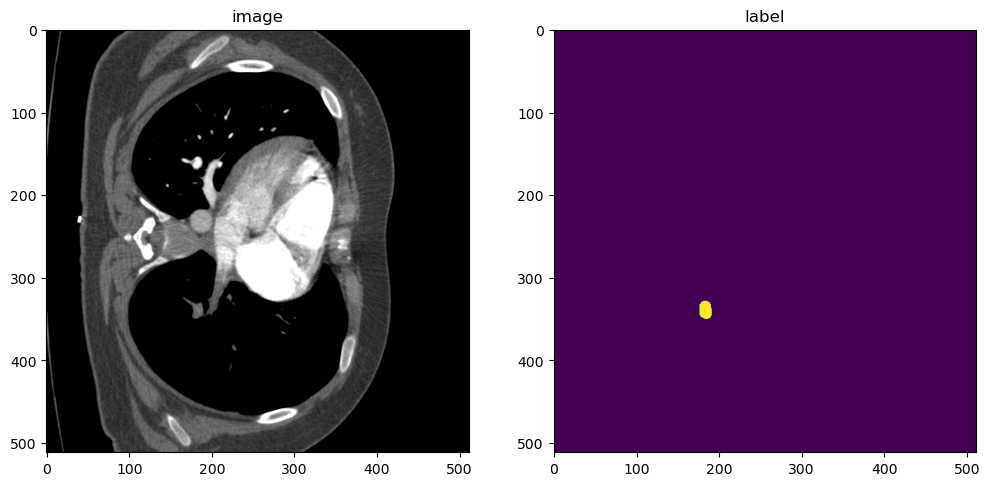

In [111]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 20]
idx = 100
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, idx], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, idx])
plt.show()

In [112]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=cache_rate, num_workers=2)
#train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=cache_rate, num_workers=2)
#val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=2)

Loading dataset: 100%|██████████| 10/10 [00:59<00:00,  5.97s/it]


In [113]:
from monai.utils import first
import numpy as np

sample = first(train_loader)

print("📦 Batch shape:", sample["image"].shape)  # (B, C, H, W, D)

for i in range(sample["label"].shape[0]):
    label_patch = sample["label"][i][0]  # [0] = squeeze channel
    pe_voxels = label_patch.sum().item()
    print(f"🧠 Patch {i}: PE voxels = {pe_voxels}")

📦 Batch shape: torch.Size([12, 1, 96, 96, 64])
🧠 Patch 0: PE voxels = 0.0
🧠 Patch 1: PE voxels = 0.0
🧠 Patch 2: PE voxels = 0.0
🧠 Patch 3: PE voxels = 0.0
🧠 Patch 4: PE voxels = 0.0
🧠 Patch 5: PE voxels = 0.0
🧠 Patch 6: PE voxels = 8343.0
🧠 Patch 7: PE voxels = 0.0
🧠 Patch 8: PE voxels = 0.0
🧠 Patch 9: PE voxels = 0.0
🧠 Patch 10: PE voxels = 8343.0
🧠 Patch 11: PE voxels = 8163.0


In [114]:
def save_checkpoint():
    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "offset": offset,
        "best_metric": best_metric,
        "best_metric_epoch": best_metric_epoch
    }, os.path.join(run_save_dir, "checkpoint.pth"))

In [115]:
device = torch.device("cuda:0")

model = UNet(
    spatial_dims=3,
    in_channels=in_channels,
    out_channels=out_channels,
    channels=channels,
    strides=strides,
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

# 🔁 Switched loss to DiceFocalLoss
loss_function = DiceFocalLoss(to_onehot_y=True, softmax=True)

optimizer = torch.optim.Adam(model.parameters(), 1e-4)

dice_metric = DiceMetric(include_background=False, reduction="mean")

In [116]:
from tqdm import tqdm, trange
import warnings
warnings.filterwarnings("ignore", message=".*unable to generate class balanced samples.*")

In [ ]:
# Optional: Load checkpoint
resume = os.path.exists(os.path.join(run_save_dir, "checkpoint.pth"))
if resume:
    checkpoint = torch.load(os.path.join(run_save_dir, "checkpoint.pth"))
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    best_metric = checkpoint["best_metric"]
    best_metric_epoch = checkpoint["best_metric_epoch"]
    print(f"[🔄] Resuming from epoch {start_epoch}, best metric {best_metric:.4f}")
else:
    start_epoch = 0
    offset = 0
    best_metric = -1
    best_metric_epoch = -1

epoch_loss_values = []
metric_values = []
epoch_range = trange(start_epoch, start_epoch + epochs, desc="Training Epochs")

# --- Training Loop ---
for epoch in epoch_range:
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    epoch_range.set_postfix({"loss": epoch_loss})
    wandb.log({"train/loss": epoch_loss, "train/lr": optimizer.param_groups[0]["lr"]}, step=epoch)

    # --- Validation ---
    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0.0
        val_steps = 0
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = val_data["image"].to(device), val_data["label"].to(device)
                val_outputs = sliding_window_inference(val_inputs, roi_size=(160, 160, 160), sw_batch_size=4, predictor=model)
                loss = loss_function(val_outputs, val_labels)
                val_loss += loss.item()
                val_steps += 1

                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                dice_metric(y_pred=val_outputs, y=val_labels)

        val_loss /= val_steps
        metric = dice_metric.aggregate().item()
        dice_metric.reset()

        metric_values.append(metric)
        wandb.log({"val/dice": metric, "val/loss": val_loss}, step=epoch)

        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            save_checkpoint()
            print("[💾] Saved new best metric model")

        if epoch % image_visual_epochs == 0:
            val_image = val_data["image"][0, 0].detach().cpu().numpy()
            val_label = val_data["label"][0, 0].detach().cpu().numpy()
            val_pred = torch.argmax(val_outputs[0], dim=0).detach().cpu().numpy()
            #mid_slice = val_image.shape[2] // 2
            mid_slice = 99
            fig, axs = plt.subplots(1, 4, figsize=(20, 5))
            axs[0].imshow(val_image[:, :, mid_slice], cmap="gray")
            axs[0].set_title("Input")
            axs[1].imshow(val_image[:, :, mid_slice], cmap="gray")
            axs[1].imshow(val_pred[:, :, mid_slice], cmap="Reds", alpha=0.4)
            axs[1].set_title("Prediction on Input")
            axs[2].imshow(val_pred[:, :, mid_slice])
            axs[2].set_title("Prediction")
            axs[3].imshow(val_label[:, :, mid_slice])
            axs[3].set_title("Ground Truth")
            plt.tight_layout()
            wandb.log({"val/visual": wandb.Image(fig)}, step=epoch)
            plt.close(fig)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

1/12, train_loss: 0.8270
2/12, train_loss: 0.8253
3/12, train_loss: 0.7984
4/12, train_loss: 0.8004
5/12, train_loss: 0.7874
6/12, train_loss: 0.8016
7/12, train_loss: 0.7940
8/12, train_loss: 0.7756
9/12, train_loss: 0.7849
10/12, train_loss: 0.7858
11/12, train_loss: 0.7716
12/12, train_loss: 0.7699
13/12, train_loss: 0.7751


Training Epochs:   0%|          | 0/50 [00:28<?, ?it/s, loss=0.792]

[💾] Saved new best metric model


Training Epochs:   2%|▏         | 1/50 [00:58<47:30, 58.18s/it, loss=0.792]

1/12, train_loss: 0.7669
2/12, train_loss: 0.7597
3/12, train_loss: 0.7523
4/12, train_loss: 0.7428
5/12, train_loss: 0.7539
6/12, train_loss: 0.7566
7/12, train_loss: 0.7492
8/12, train_loss: 0.7294
9/12, train_loss: 0.7363
10/12, train_loss: 0.7390
11/12, train_loss: 0.7507
12/12, train_loss: 0.7460
13/12, train_loss: 0.7438


Training Epochs:   4%|▍         | 2/50 [01:47<42:35, 53.24s/it, loss=0.748]

1/12, train_loss: 0.7366
2/12, train_loss: 0.7327
3/12, train_loss: 0.7409
4/12, train_loss: 0.7378
5/12, train_loss: 0.7353
6/12, train_loss: 0.7231
7/12, train_loss: 0.7122
8/12, train_loss: 0.7294
9/12, train_loss: 0.7210
10/12, train_loss: 0.7317
11/12, train_loss: 0.7113
12/12, train_loss: 0.7299
13/12, train_loss: 0.7152


Training Epochs:   6%|▌         | 3/50 [02:38<40:36, 51.84s/it, loss=0.727]

[💾] Saved new best metric model
1/12, train_loss: 0.7082
2/12, train_loss: 0.7133
3/12, train_loss: 0.6992
4/12, train_loss: 0.7074
5/12, train_loss: 0.7128
6/12, train_loss: 0.7085
7/12, train_loss: 0.6986
8/12, train_loss: 0.7136
9/12, train_loss: 0.7148
10/12, train_loss: 0.7192
11/12, train_loss: 0.7238
12/12, train_loss: 0.7092
13/12, train_loss: 0.7161


Training Epochs:   8%|▊         | 4/50 [03:29<39:32, 51.58s/it, loss=0.711]

[💾] Saved new best metric model
1/12, train_loss: 0.7053
2/12, train_loss: 0.7065
3/12, train_loss: 0.7010
4/12, train_loss: 0.7073
5/12, train_loss: 0.6746
6/12, train_loss: 0.6876
7/12, train_loss: 0.6901
8/12, train_loss: 0.7060
9/12, train_loss: 0.6964
10/12, train_loss: 0.7124
11/12, train_loss: 0.6921
12/12, train_loss: 0.7024
13/12, train_loss: 0.6413


Training Epochs:  10%|█         | 5/50 [04:22<39:05, 52.11s/it, loss=0.694]

[💾] Saved new best metric model
1/12, train_loss: 0.6950
2/12, train_loss: 0.6656
3/12, train_loss: 0.6936
4/12, train_loss: 0.6924
5/12, train_loss: 0.7031
6/12, train_loss: 0.6663
7/12, train_loss: 0.6941
8/12, train_loss: 0.6979
9/12, train_loss: 0.6583
10/12, train_loss: 0.6732
11/12, train_loss: 0.6781
12/12, train_loss: 0.7026
13/12, train_loss: 0.6997


Training Epochs:  12%|█▏        | 6/50 [05:15<38:21, 52.30s/it, loss=0.686]

[💾] Saved new best metric model
1/12, train_loss: 0.6612
2/12, train_loss: 0.6909
3/12, train_loss: 0.6710
4/12, train_loss: 0.6729
5/12, train_loss: 0.6762
6/12, train_loss: 0.6773
7/12, train_loss: 0.6758
8/12, train_loss: 0.7017
9/12, train_loss: 0.6683
10/12, train_loss: 0.6721
11/12, train_loss: 0.6548
12/12, train_loss: 0.6864
13/12, train_loss: 0.6860


Training Epochs:  14%|█▍        | 7/50 [06:05<36:56, 51.54s/it, loss=0.677]

[💾] Saved new best metric model
1/12, train_loss: 0.6600
2/12, train_loss: 0.6569
3/12, train_loss: 0.6740
4/12, train_loss: 0.6315
5/12, train_loss: 0.6631
6/12, train_loss: 0.6780
7/12, train_loss: 0.6805
8/12, train_loss: 0.6767
9/12, train_loss: 0.6787
10/12, train_loss: 0.6653
11/12, train_loss: 0.6523
12/12, train_loss: 0.6542
13/12, train_loss: 0.6436


Training Epochs:  16%|█▌        | 8/50 [06:56<36:07, 51.61s/it, loss=0.663]

[💾] Saved new best metric model
1/12, train_loss: 0.6648
2/12, train_loss: 0.6651
3/12, train_loss: 0.6658
4/12, train_loss: 0.6806
5/12, train_loss: 0.6521
6/12, train_loss: 0.6145
7/12, train_loss: 0.6776
8/12, train_loss: 0.6635
9/12, train_loss: 0.6431
10/12, train_loss: 0.6486
11/12, train_loss: 0.6680
12/12, train_loss: 0.6651
13/12, train_loss: 0.6399


Training Epochs:  18%|█▊        | 9/50 [07:47<35:07, 51.41s/it, loss=0.658]

1/12, train_loss: 0.6458
2/12, train_loss: 0.6482
3/12, train_loss: 0.6457
4/12, train_loss: 0.6567
5/12, train_loss: 0.6599
6/12, train_loss: 0.6355
7/12, train_loss: 0.6318
8/12, train_loss: 0.6704
9/12, train_loss: 0.6526
10/12, train_loss: 0.6462
11/12, train_loss: 0.6482
12/12, train_loss: 0.6348
13/12, train_loss: 0.6655


Training Epochs:  20%|██        | 10/50 [08:38<34:06, 51.15s/it, loss=0.649]

1/12, train_loss: 0.6529
2/12, train_loss: 0.6335
3/12, train_loss: 0.6692
4/12, train_loss: 0.6622
5/12, train_loss: 0.6558
6/12, train_loss: 0.6513
7/12, train_loss: 0.6216
8/12, train_loss: 0.6505
9/12, train_loss: 0.5773
10/12, train_loss: 0.6193
11/12, train_loss: 0.6454
12/12, train_loss: 0.6559
13/12, train_loss: 0.6392


Training Epochs:  22%|██▏       | 11/50 [09:32<33:53, 52.15s/it, loss=0.641]

1/12, train_loss: 0.6210
2/12, train_loss: 0.6360
3/12, train_loss: 0.5988
4/12, train_loss: 0.6447
5/12, train_loss: 0.6085
6/12, train_loss: 0.6503
7/12, train_loss: 0.6414
8/12, train_loss: 0.6430
9/12, train_loss: 0.6350
10/12, train_loss: 0.5985
11/12, train_loss: 0.6575
12/12, train_loss: 0.6303
13/12, train_loss: 0.6527


Training Epochs:  24%|██▍       | 12/50 [10:23<32:44, 51.70s/it, loss=0.632]

1/12, train_loss: 0.6415
2/12, train_loss: 0.6472
3/12, train_loss: 0.5937
4/12, train_loss: 0.6119
5/12, train_loss: 0.6231
6/12, train_loss: 0.6287
7/12, train_loss: 0.6301
8/12, train_loss: 0.6269
9/12, train_loss: 0.6190
10/12, train_loss: 0.6351
11/12, train_loss: 0.6537
12/12, train_loss: 0.6377
13/12, train_loss: 0.5656


Training Epochs:  26%|██▌       | 13/50 [11:17<32:23, 52.51s/it, loss=0.624]

[💾] Saved new best metric model
1/12, train_loss: 0.6344
2/12, train_loss: 0.6111
3/12, train_loss: 0.6285
4/12, train_loss: 0.6246
5/12, train_loss: 0.6334
6/12, train_loss: 0.6139
7/12, train_loss: 0.6181
8/12, train_loss: 0.6239
9/12, train_loss: 0.6399
10/12, train_loss: 0.5954
11/12, train_loss: 0.6199
12/12, train_loss: 0.5631
13/12, train_loss: 0.6460


Training Epochs:  28%|██▊       | 14/50 [12:09<31:18, 52.17s/it, loss=0.619]

1/12, train_loss: 0.6046
2/12, train_loss: 0.6319
3/12, train_loss: 0.5985
4/12, train_loss: 0.6372
5/12, train_loss: 0.6052
6/12, train_loss: 0.6188
7/12, train_loss: 0.6267
8/12, train_loss: 0.6075
9/12, train_loss: 0.5724
10/12, train_loss: 0.6051
11/12, train_loss: 0.5757
12/12, train_loss: 0.6159
13/12, train_loss: 0.6397


Training Epochs:  30%|███       | 15/50 [13:00<30:19, 51.99s/it, loss=0.611]

1/12, train_loss: 0.6321
2/12, train_loss: 0.6022
3/12, train_loss: 0.5918
4/12, train_loss: 0.5634
5/12, train_loss: 0.6178
6/12, train_loss: 0.6307
7/12, train_loss: 0.6303
8/12, train_loss: 0.6057
9/12, train_loss: 0.5884
10/12, train_loss: 0.6187
11/12, train_loss: 0.5825
12/12, train_loss: 0.6059
13/12, train_loss: 0.6151


Training Epochs:  32%|███▏      | 16/50 [13:52<29:24, 51.89s/it, loss=0.607]

1/12, train_loss: 0.6225
2/12, train_loss: 0.6189
3/12, train_loss: 0.5890
4/12, train_loss: 0.6475
5/12, train_loss: 0.6099
6/12, train_loss: 0.5916
7/12, train_loss: 0.6116
8/12, train_loss: 0.5526
9/12, train_loss: 0.6365
10/12, train_loss: 0.5375
11/12, train_loss: 0.5845
12/12, train_loss: 0.6056
13/12, train_loss: 0.5985


Training Epochs:  34%|███▍      | 17/50 [14:43<28:23, 51.61s/it, loss=0.6]  

1/12, train_loss: 0.6170
2/12, train_loss: 0.5926
3/12, train_loss: 0.5374
4/12, train_loss: 0.6221
5/12, train_loss: 0.6198
6/12, train_loss: 0.6058
7/12, train_loss: 0.5593
8/12, train_loss: 0.6231
9/12, train_loss: 0.5869
10/12, train_loss: 0.5829
11/12, train_loss: 0.5934
12/12, train_loss: 0.6050
13/12, train_loss: 0.6125


Training Epochs:  36%|███▌      | 18/50 [15:33<27:19, 51.25s/it, loss=0.597]

[💾] Saved new best metric model
1/12, train_loss: 0.6114
2/12, train_loss: 0.5895
3/12, train_loss: 0.5878
4/12, train_loss: 0.5988
5/12, train_loss: 0.5688
6/12, train_loss: 0.5440
7/12, train_loss: 0.5770
8/12, train_loss: 0.5932
9/12, train_loss: 0.5729
10/12, train_loss: 0.6257
11/12, train_loss: 0.5934
12/12, train_loss: 0.6091
13/12, train_loss: 0.5868


Training Epochs:  38%|███▊      | 19/50 [16:25<26:33, 51.39s/it, loss=0.589]

1/12, train_loss: 0.5602
2/12, train_loss: 0.5730
3/12, train_loss: 0.5747
4/12, train_loss: 0.6033
5/12, train_loss: 0.6166
6/12, train_loss: 0.5789
7/12, train_loss: 0.5709
8/12, train_loss: 0.6076
9/12, train_loss: 0.5967
10/12, train_loss: 0.5394
11/12, train_loss: 0.6144
12/12, train_loss: 0.5908
13/12, train_loss: 0.5719


Training Epochs:  40%|████      | 20/50 [17:17<25:48, 51.63s/it, loss=0.584]

1/12, train_loss: 0.5862
2/12, train_loss: 0.5823
3/12, train_loss: 0.6079
4/12, train_loss: 0.5865
5/12, train_loss: 0.5878
6/12, train_loss: 0.5331
7/12, train_loss: 0.5457
8/12, train_loss: 0.5501
9/12, train_loss: 0.6025
10/12, train_loss: 0.6009
11/12, train_loss: 0.5641
12/12, train_loss: 0.5442
13/12, train_loss: 0.5553


Training Epochs:  42%|████▏     | 21/50 [18:10<25:05, 51.93s/it, loss=0.573]

1/12, train_loss: 0.5217
2/12, train_loss: 0.5800
3/12, train_loss: 0.6115
4/12, train_loss: 0.6093
5/12, train_loss: 0.5673
6/12, train_loss: 0.5146
7/12, train_loss: 0.5418
8/12, train_loss: 0.5930
9/12, train_loss: 0.5959
10/12, train_loss: 0.5763
11/12, train_loss: 0.5331
12/12, train_loss: 0.5972
13/12, train_loss: 0.5854


Training Epochs:  44%|████▍     | 22/50 [19:02<24:16, 52.03s/it, loss=0.571]

1/12, train_loss: 0.5530
2/12, train_loss: 0.5429
3/12, train_loss: 0.5979
4/12, train_loss: 0.5790
5/12, train_loss: 0.5344
6/12, train_loss: 0.5950
7/12, train_loss: 0.5929
8/12, train_loss: 0.5834
9/12, train_loss: 0.5599
10/12, train_loss: 0.5365
11/12, train_loss: 0.5686
12/12, train_loss: 0.5643
13/12, train_loss: 0.5963


Training Epochs:  46%|████▌     | 23/50 [19:53<23:17, 51.74s/it, loss=0.57] 

1/12, train_loss: 0.6005
2/12, train_loss: 0.5646
3/12, train_loss: 0.6057
4/12, train_loss: 0.5469
5/12, train_loss: 0.5414
6/12, train_loss: 0.5460
7/12, train_loss: 0.5604
8/12, train_loss: 0.5940
9/12, train_loss: 0.5859
10/12, train_loss: 0.5317
11/12, train_loss: 0.5469
12/12, train_loss: 0.5609
13/12, train_loss: 0.4863


Training Epochs:  48%|████▊     | 24/50 [20:44<22:18, 51.48s/it, loss=0.559]

1/12, train_loss: 0.5609
2/12, train_loss: 0.5671
3/12, train_loss: 0.5438
4/12, train_loss: 0.4734
5/12, train_loss: 0.5886
6/12, train_loss: 0.5345
7/12, train_loss: 0.5866
8/12, train_loss: 0.5748
9/12, train_loss: 0.5391
10/12, train_loss: 0.5845
11/12, train_loss: 0.5779
12/12, train_loss: 0.5076
13/12, train_loss: 0.5444


Training Epochs:  50%|█████     | 25/50 [21:36<21:27, 51.50s/it, loss=0.553]

1/12, train_loss: 0.5234
2/12, train_loss: 0.5495
3/12, train_loss: 0.5240
4/12, train_loss: 0.5818
5/12, train_loss: 0.5522
6/12, train_loss: 0.5881
7/12, train_loss: 0.5424
8/12, train_loss: 0.5170
9/12, train_loss: 0.4987
10/12, train_loss: 0.4891
11/12, train_loss: 0.5542
12/12, train_loss: 0.5798
13/12, train_loss: 0.5445


Training Epochs:  52%|█████▏    | 26/50 [22:26<20:28, 51.20s/it, loss=0.542]

1/12, train_loss: 0.5807
2/12, train_loss: 0.4684
3/12, train_loss: 0.5309
4/12, train_loss: 0.5645
5/12, train_loss: 0.5428
6/12, train_loss: 0.5838
7/12, train_loss: 0.4563
8/12, train_loss: 0.5495
9/12, train_loss: 0.5414
10/12, train_loss: 0.5565
11/12, train_loss: 0.5575
12/12, train_loss: 0.5646
13/12, train_loss: 0.5711


Training Epochs:  54%|█████▍    | 27/50 [23:18<19:44, 51.51s/it, loss=0.544]

[💾] Saved new best metric model
1/12, train_loss: 0.5462
2/12, train_loss: 0.5132
3/12, train_loss: 0.5661
4/12, train_loss: 0.5353
5/12, train_loss: 0.4895
6/12, train_loss: 0.5315
7/12, train_loss: 0.5709
8/12, train_loss: 0.5510
9/12, train_loss: 0.5346
10/12, train_loss: 0.4814
11/12, train_loss: 0.5176
12/12, train_loss: 0.5827
13/12, train_loss: 0.5834


Training Epochs:  56%|█████▌    | 28/50 [24:10<18:55, 51.60s/it, loss=0.539]

1/12, train_loss: 0.5341
2/12, train_loss: 0.5277
3/12, train_loss: 0.5304
4/12, train_loss: 0.5710
5/12, train_loss: 0.5694
6/12, train_loss: 0.4969
7/12, train_loss: 0.5030
8/12, train_loss: 0.5621
9/12, train_loss: 0.4844
10/12, train_loss: 0.5392
11/12, train_loss: 0.5373
12/12, train_loss: 0.5775
13/12, train_loss: 0.5715


Training Epochs:  58%|█████▊    | 29/50 [25:01<17:57, 51.30s/it, loss=0.539]

1/12, train_loss: 0.4650
2/12, train_loss: 0.5210
3/12, train_loss: 0.5590
4/12, train_loss: 0.5237
5/12, train_loss: 0.5683
6/12, train_loss: 0.5353
7/12, train_loss: 0.5051
8/12, train_loss: 0.5205
9/12, train_loss: 0.5596
10/12, train_loss: 0.5277
11/12, train_loss: 0.4947
12/12, train_loss: 0.5216
13/12, train_loss: 0.4855


Training Epochs:  60%|██████    | 30/50 [25:52<17:05, 51.27s/it, loss=0.522]

1/12, train_loss: 0.4827
2/12, train_loss: 0.5199
3/12, train_loss: 0.5442
4/12, train_loss: 0.5066
5/12, train_loss: 0.5146
6/12, train_loss: 0.5053
7/12, train_loss: 0.5523
8/12, train_loss: 0.5436
9/12, train_loss: 0.4678
10/12, train_loss: 0.5560
11/12, train_loss: 0.5637
12/12, train_loss: 0.5366
13/12, train_loss: 0.5200


Training Epochs:  60%|██████    | 30/50 [26:18<17:05, 51.27s/it, loss=0.524]

In [ ]:
model.load_state_dict(torch.load(os.path.join(run_save_dir, "best_metric_model.pth"), weights_only=True))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        idx = 150
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :,idx], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, idx])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, idx])
        plt.show()
        if i == 2:
            break

## Find good validation sample

In [52]:
val_data_sample = next(iter(val_loader))
val_inputs = val_data_sample["image"].to(device)
val_labels = val_data_sample["label"].to(device)

In [53]:
roi_size = (160, 160, 160)
sw_batch_size = 1
val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)

In [54]:
import numpy as np

image_np = val_inputs[0, 0].detach().cpu().numpy()
label_np = val_labels[0, 0].detach().cpu().numpy()
pred_np = torch.argmax(val_outputs[0], dim=0).detach().cpu().numpy()

# Find slices that contain at least one PE voxel
non_empty_slices = np.where(label_np.sum(axis=(0,1)) > 0)[0]
print(f"Slices with PE: {non_empty_slices}")

Slices with PE: [ 59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184]


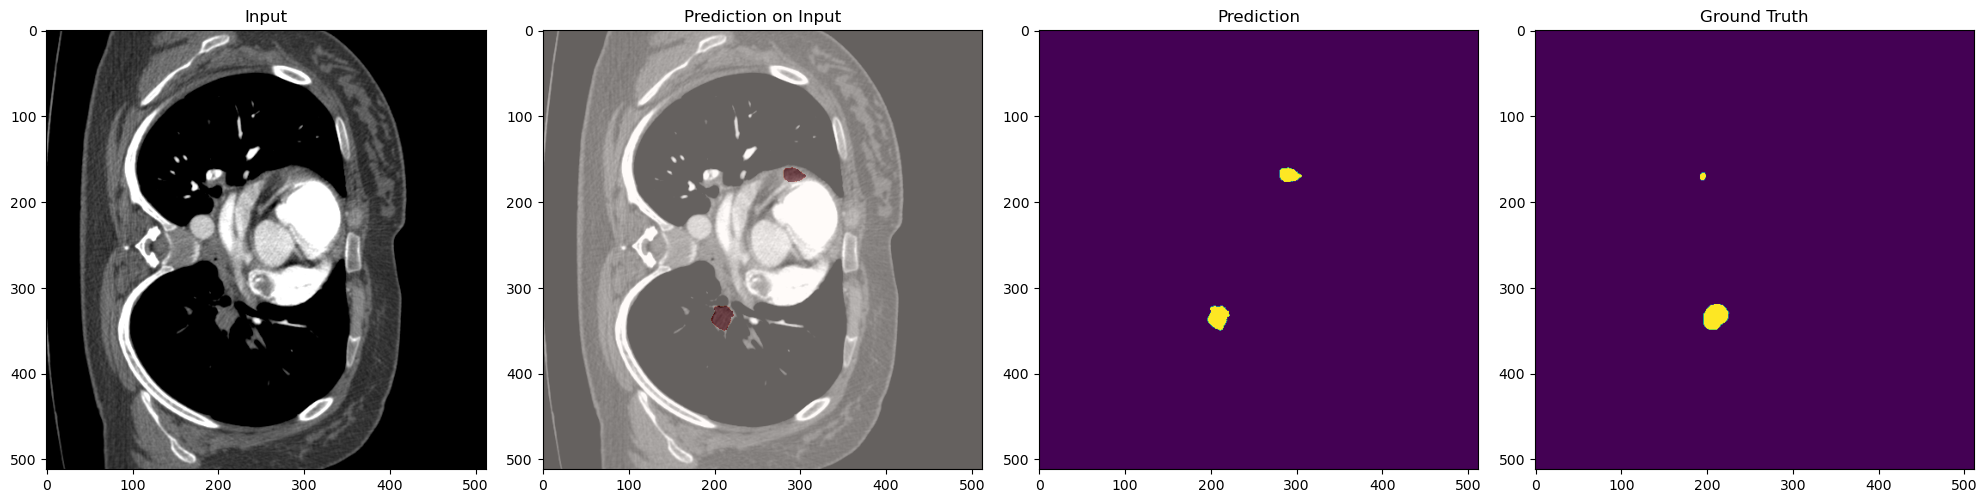

In [55]:
slice_idx = non_empty_slices[len(non_empty_slices)//2]  # pick center PE slice

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(image_np[:, :, slice_idx], cmap="gray")
axs[0].set_title("Input")

axs[1].imshow(image_np[:, :, slice_idx], cmap="gray")
axs[1].imshow(pred_np[:, :, slice_idx], cmap="Reds", alpha=0.4)
axs[1].set_title("Prediction on Input")

axs[2].imshow(pred_np[:, :, slice_idx])
axs[2].set_title("Prediction")

axs[3].imshow(label_np[:, :, slice_idx])
axs[3].set_title("Ground Truth")

plt.tight_layout()
plt.show()

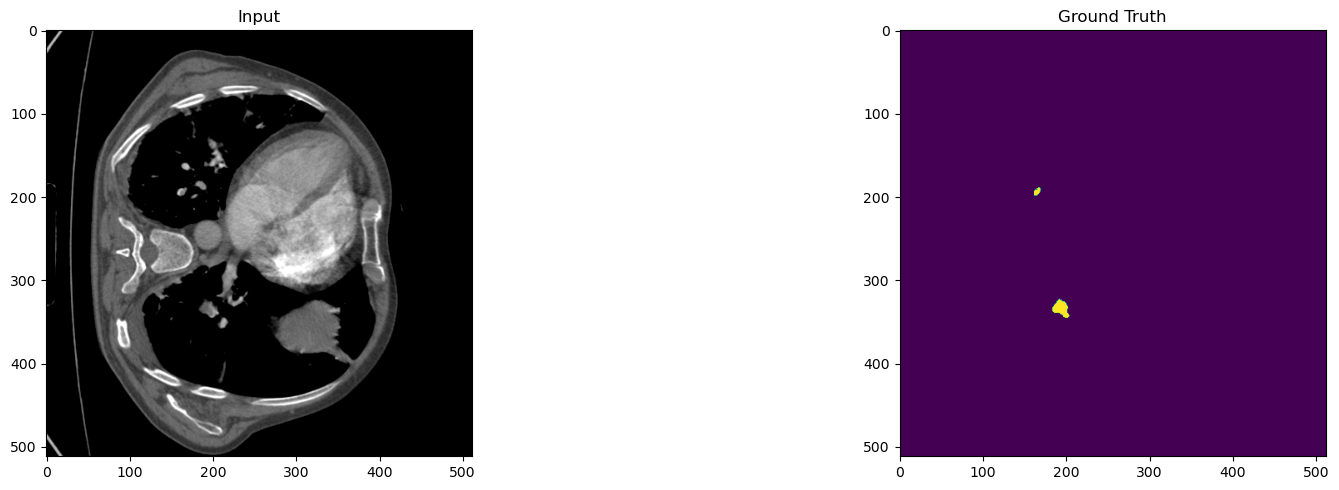

In [94]:
val_image = val_data["image"][0, 0].detach().cpu().numpy()
val_label = val_data["label"][0, 0].detach().cpu().numpy()
mid_slice = 99
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].imshow(val_image[:, :, mid_slice], cmap="gray")
axs[0].set_title("Input")
axs[1].imshow(val_label[:, :, mid_slice])
axs[1].set_title("Ground Truth")
plt.tight_layout()
plt.show()

In [93]:
val_image = val_data["image"][0, 0].detach().cpu().numpy()
val_label = val_data["label"][0, 0].detach().cpu().numpy()

# Get total number of slices
num_slices = val_label.shape[2]

# Loop through slices and compute mask sum
for slice_idx in range(num_slices):
    mask_sum = val_label[:, :, slice_idx].sum()
    print(f"Slice {slice_idx:03d}: mask sum = {int(mask_sum)}")

Slice 000: mask sum = 0
Slice 001: mask sum = 0
Slice 002: mask sum = 0
Slice 003: mask sum = 0
Slice 004: mask sum = 0
Slice 005: mask sum = 0
Slice 006: mask sum = 0
Slice 007: mask sum = 0
Slice 008: mask sum = 0
Slice 009: mask sum = 0
Slice 010: mask sum = 280
Slice 011: mask sum = 0
Slice 012: mask sum = 0
Slice 013: mask sum = 0
Slice 014: mask sum = 0
Slice 015: mask sum = 0
Slice 016: mask sum = 0
Slice 017: mask sum = 0
Slice 018: mask sum = 0
Slice 019: mask sum = 0
Slice 020: mask sum = 0
Slice 021: mask sum = 0
Slice 022: mask sum = 0
Slice 023: mask sum = 0
Slice 024: mask sum = 0
Slice 025: mask sum = 0
Slice 026: mask sum = 0
Slice 027: mask sum = 0
Slice 028: mask sum = 0
Slice 029: mask sum = 0
Slice 030: mask sum = 0
Slice 031: mask sum = 0
Slice 032: mask sum = 0
Slice 033: mask sum = 0
Slice 034: mask sum = 0
Slice 035: mask sum = 0
Slice 036: mask sum = 0
Slice 037: mask sum = 0
Slice 038: mask sum = 0
Slice 039: mask sum = 0
Slice 040: mask sum = 0
Slice 041: mas